# Setup

In [ ]:
SAVE_DIR = "./static/assets/svg/figure"

In [ ]:
from pathlib import Path

# folder of the current notebook
NOTEBOOK_DIR = Path().resolve()

outdir = NOTEBOOK_DIR / "context" / "app" / "static" / "assets" / "svg" / "figure"
outdir.mkdir(parents=True, exist_ok=True)

In [ ]:
# Import the required packages
%pip install numpy pandas requests matplotlib

import requests
import json
import math
import textwrap
import re

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.patches import Patch
from matplotlib.font_manager import FontProperties

from IPython.display import display, HTML, SVG
from html import escape

In [ ]:
# Constants

search_api = "https://search.api.hubmapconsortium.org/v3/portal/search"

bar_colors = {
    "default": "steelblue",
    "secondary": "lightblue",
}

plt.rcParams["font.family"] = "Helvetica"

In [ ]:
# Helper functions

from matplotlib.text import Text
from typing import Iterable, List, Optional, Union, Dict
import numpy as np

def label_bars_dynamic(
    ax,
    bars: Iterable,
    values: Optional[Iterable[Union[int, float]]] = None,
    fmt: str = "{:,}",
    threshold: float = 0.85,   # fraction of axis span at which to flip inside
    pad: float = 0.01,         # fraction of axis span used as label offset
    inside_style: Optional[Dict] = None,
    outside_style: Optional[Dict] = None,
) -> List[Text]:
    """
    Add value labels to bars, placing them *inside* the bar (white/bold by default)
    when the bar occupies more than `threshold` of the axis span, otherwise outside.

    Works for both horizontal (barh) and vertical (bar) charts.
    - If `values` is None, they’re inferred from bar sizes.
    - `threshold` and `pad` are fractions of the current axis limits.

    Returns the list of created Text objects.
    """
    bars = list(bars)
    if not bars:
        return []

    # Heuristic to detect orientation
    mean_w = np.mean([b.get_width() for b in bars])
    mean_h = np.mean([b.get_height() for b in bars])
    horizontal = bool(mean_w > mean_h)  # True → barh; False → bar

    # Axis span for positioning & padding
    if horizontal:
        axis_min, axis_max = ax.get_xlim()
        span = axis_max - axis_min
        # infer values if not provided
        if values is None:
            values = [b.get_width() for b in bars]
    else:
        axis_min, axis_max = ax.get_ylim()
        span = axis_max - axis_min
        if values is None:
            values = [b.get_height() for b in bars]

    values = list(values)

    # Default styles (can be overridden)
    if inside_style is None:
        inside_style = dict(color="white", fontweight="700", fontsize=12, ha="right", va="center")
    if outside_style is None:
        # outside style defaults depend on orientation; we'll adjust ha/va below
        outside_style = dict(color="black", fontsize=12)

    texts: List[Text] = []
    flip_point = axis_min + threshold * span
    nudge = pad * span

    for bar, val in zip(bars, values):
        if horizontal:
            y = bar.get_y() + bar.get_height() / 2.0
            if val >= (flip_point - (0 if axis_min == 0 else axis_min)):
                x = val - nudge
                style = {**inside_style, "ha": "right", "va": "center"}
            else:
                x = val + nudge
                style = {**outside_style, "ha": "left", "va": "center"}
        else:
            x = bar.get_x() + bar.get_width() / 2.0
            if val >= (flip_point - (0 if axis_min == 0 else axis_min)):
                y = val - nudge
                style = {**inside_style, "va": "top", "ha": "center"}
            else:
                y = val + nudge
                style = {**outside_style, "va": "bottom", "ha": "center"}

        txt = ax.text(x if horizontal else x,
                      y if horizontal else y,
                      fmt.format(val),
                      **style)
        texts.append(txt)

    return texts


# Panel b

In [ ]:
hits = json.loads(
    requests.post(
        search_api,
        json={
          "size": 0,
          "query": {
              "bool": {
                  "must": [
                      {"term": {"entity_type.keyword": "Donor"}},
                      {"exists": {"field": "mapped_metadata.age_value"}},
                      {"exists": {"field": "mapped_metadata.sex"}}
                  ]
              }
          },
          "aggs": {
              "by_sex": {
                  "terms": {
                      "field": "mapped_metadata.sex.keyword",
                      "size": 2
                  },
                  "aggs": {
                      "age_distribution": {
                          "histogram": {
                              "field": "mapped_metadata.age_value",
                              "interval": 10
                          }
                      }
                  }
              }
          }
      }
    ).text
)['aggregations']['by_sex']['buckets']


# Extract (age_bin -> count) mappings for each sex
female_age_counts = {b["key"]: b["doc_count"] for b in hits[0]["age_distribution"]["buckets"]}
male_age_counts   = {b["key"]: b["doc_count"] for b in hits[1]["age_distribution"]["buckets"]}

# Union of all age bins (ensure alignment even if one sex is missing a bin)
all_ages = sorted(set(female_age_counts.keys()) | set(male_age_counts.keys()))

# Build aligned series
female_vals = [female_age_counts.get(age, 0) for age in all_ages]
male_vals   = [male_age_counts.get(age, 0) for age in all_ages]

# Grand total donors
grand_total = sum(female_vals) + sum(male_vals)

# Choose a bar width appropriate for your binning
bar_width = 8

fig, ax = plt.subplots(figsize=(10, 6))

# Stacked bars
female_bars = ax.bar(
    all_ages,
    female_vals,
    width=bar_width,
    label="Female",
    color=bar_colors["secondary"]
)
male_bars = ax.bar(
    all_ages,
    male_vals,
    width=bar_width,
    bottom=female_vals,
    label="Male",
    color=bar_colors["default"]
)

ax.set_xlabel("Age Group", fontsize=18)
ax.set_ylabel("Donor Count", fontsize=18)
ax.set_xticks(all_ages)

# Make tick labels bigger
ax.tick_params(axis="both", which="major", labelsize=18)

# Add a bold, left-aligned "Total Donors" entry to the legend
total_patch = Patch(facecolor="none", edgecolor="none")
bold_font = FontProperties(weight="bold")

handles = [female_bars, male_bars, total_patch]
labels  = ["Female", "Male", f"Total Donors: {grand_total:,}"]

legend = ax.legend(handles, labels, loc="best", frameon=True, fontsize=18)

# Style the total entry
for text, label in zip(legend.get_texts(), labels):
    if label.startswith("Total Donors"):
        text.set_fontproperties(bold_font)
        text.set_fontsize(18)
        text.set_ha("left")
        text.set_position((-20, 0))

ax.text(
    -0.1, 0.98, "b",
    transform=ax.transAxes,
    fontsize=35, fontweight="bold",
    va="top", ha="left"
)

plt.tight_layout()
fig.savefig(outdir / "figure_1b.svg", format="svg")
plt.show()

# Panel c

In [ ]:
hits = json.loads(
    requests.post(
        search_api,
        json={
            "size": 0,
            "query": {
                "bool": {
                    "must": [
                        {"term": {"entity_type.keyword": "Donor"}},
                        {"exists": {"field": "mapped_metadata.race"}},
                        {"exists": {"field": "mapped_metadata.sex"}}
                    ]
                }
            },
            "aggs": {
                "by_sex": {
                    "terms": {
                        "field": "mapped_metadata.sex.keyword",
                        "size": 2
                    },
                    "aggs": {
                        "race_breakdown": {
                            "terms": {
                                "field": "mapped_metadata.race.keyword",
                                "size": 10
                            }
                        }
                    }
                }
            }
        }
    ).text
)['aggregations']['by_sex']['buckets']

races = sorted({b['key'] for g in hits for b in g['race_breakdown']['buckets']})

# Initialize count dicts
male_counts = {r: 0 for r in races}
female_counts = {r: 0 for r in races}

# Fill counts per race per sex
for g in hits:
    sex = g.get('key', '')
    for b in g['race_breakdown']['buckets']:
        race = b['key']
        count = b['doc_count']
        if sex == "Male":
            male_counts[race] = count
        elif sex == "Female":
            female_counts[race] = count

# Compute totals for sorting
totals = {race: male_counts[race] + female_counts[race] for race in races}
races_sorted = sorted(races, key=lambda r: totals[r])

male_vals_sorted   = [male_counts[r] for r in races_sorted]
female_vals_sorted = [female_counts[r] for r in races_sorted]
grand_total = sum(totals.values())

fig, ax = plt.subplots(figsize=(10, 6))

# Female bars (bottom part of the stack)
female_bars = ax.bar(
    races_sorted,
    female_vals_sorted,
    width=0.6,
    label="Female",
    color=bar_colors["secondary"]
)

# Male bars (stacked on top of female)
male_bars = ax.bar(
    races_sorted,
    male_vals_sorted,
    width=0.6,
    bottom=female_vals_sorted,
    label="Male",
    color=bar_colors["default"]
)

ax.set_ylabel("Donor Count", fontsize=18)
ax.set_xlabel("Race", fontsize=18)
ax.tick_params(axis="both", which="major", labelsize=14)

# --- Step 1: use abbreviated or blank x-axis labels ---
max_label_len = 15
tick_labels = [
    label if len(label) <= max_label_len else ""  # hide long ones
    for label in races_sorted
]
ax.set_xticks(range(len(races_sorted)))
ax.set_xticklabels(tick_labels, rotation=0, ha="center")

# --- Step 2: manually place long labels above bars ---
for i, label in enumerate(races_sorted):
    if len(label) > max_label_len:
        bar_height = female_vals_sorted[i] + male_vals_sorted[i]
        ax.text(
            i,                        # x position (bar center)
            bar_height + 0.5,         # y position (just above the bar)
            "\n".join(textwrap.wrap(label, 12)),  # wrap if needed
            ha="center", va="bottom",
            fontsize=12, rotation=0
        )

# Dummy entry for total donors
total_patch = Patch(facecolor="none", edgecolor="none")
bold_font = FontProperties(weight="bold")

handles = [female_bars, male_bars, total_patch]
labels = ["Female", "Male", f"Total Donors: {grand_total:,}"]

legend = ax.legend(handles, labels, loc="upper left", frameon=True, fontsize=14)

for text, label in zip(legend.get_texts(), labels):
    if label.startswith("Total Donors"):
        text.set_fontproperties(bold_font)
        text.set_fontsize(16)
        text.set_ha("left")

ax.text(
    -0.1, 0.98, "c",
    transform=ax.transAxes,
    fontsize=35, fontweight="bold",
    va="top", ha="left"
)

plt.tight_layout()
fig.savefig(outdir / "figure_1c.svg", format="svg")
plt.show()


# Panel d

In [ ]:
hits = json.loads(
    requests.post(
        search_api,
        json={
            "size": 0,
            "query": {
                "bool": {
                    "must_not": {
                        "terms": {
                            "mapped_status.keyword": ["Invalid", "Error", "New", "Processing", "Submitted"]
                        }
                    },
                    "must": {
                        "bool": {
                            "must": [
                                {
                                    "term": {
                                        "entity_type.keyword": "Dataset"
                                    }
                                }
                            ]
                        }
                    }
                }
            },
            "aggs": {
                "samples_by_origin_organ": {
                    "terms": {
                        "field": "origin_samples_unique_mapped_organs.keyword",
                        "size": 100
                    },
                    "aggs": {
                        "assay_types": {
                            "terms": {
                                "field": "raw_dataset_type.keyword",
                                "size": 50
                            }
                        }
                    }
                }
            }
        }
    ).text
)['aggregations']['samples_by_origin_organ']['buckets']


# Sort data by total doc_count in descending order
data_sorted = sorted(hits, key=lambda x: x['doc_count'])

# Extract organs and their total counts
organs = [item['key'] for item in data_sorted]
total_counts = [item['doc_count'] for item in data_sorted]
organs_sorted = organs
organ_values_sorted = total_counts

fig2, ax2 = plt.subplots(figsize=(14, max(3, 0.35 * len(organs_sorted))))

# Add zebra striping (alternate row shading)
for i in range(len(organs_sorted)):
    if i % 2 == 0:  # shade every other row
        ax2.axhspan(i - 0.5, i + 0.5, facecolor="lightgray", alpha=0.2, zorder=0)

# Plot bars
bars2 = ax2.barh(organs_sorted, organ_values_sorted, color=bar_colors["default"], zorder=3)

label_bars_dynamic(
    ax2,
    bars2,
    values=organ_values_sorted,
    fmt="{:,}",
    threshold=0.80,
    pad=0.01
)

ax2.set_xlabel('Dataset Count', fontsize=14)
ax2.set_ylabel('Organ Class', fontsize=14)

ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14)

ax2.invert_yaxis()
ax2.set_ylim(-0.5, len(organs_sorted) - 0.5)

fig2.tight_layout()

ax2.text(
    -0.3, 1, "d",
    transform=ax2.transAxes,
    fontsize=22, fontweight="bold",
    va="top", ha="left"
)

fig2.savefig(outdir / "figure_1d.svg", format="svg")
plt.show()


# Panels e-g

In [ ]:
hits = json.loads(
    requests.post(
        search_api,
        json={
            "size": 0,
            "query": {
                "bool": {
                    "must_not": {
                        "terms": {
                            "mapped_status.keyword": ["Invalid", "Error", "New", "Processing", "Submitted"]
                        }
                    },
                    "must": {
                        "bool": {
                            "must": [
                                {"term": {"entity_type.keyword": "Sample"}}
                            ]
                        }
                    }
                }
            },
            "aggs": {
                "samples_by_organ": {
                    "terms": {
                        "field": "origin_samples_unique_mapped_organs.keyword",
                        "size": 100
                    },
                    "aggs": {
                        "unique_donors": {
                            "cardinality": {"field": "donor.uuid.keyword"}
                        }
                    }
                }
            }
        }
    ).text
)['aggregations']['samples_by_organ']['buckets']

from matplotlib.patches import Rectangle

rows = []
for b in hits:
    organ = b["key"]
    samples_val = int(b["doc_count"])
    donors_val = int(b["unique_donors"]["value"])
    mean_val = (samples_val / donors_val) if donors_val else 0.0
    rows.append((organ, donors_val, samples_val, mean_val))

vals_by_organ = {org: (don, sam, mn) for org, don, sam, mn in rows}
organ_order = organs_sorted

# If c has an organ not in d, append at the end; if d has organs missing in c, they'll show 0s.
extras_c = [o for o in vals_by_organ.keys() if o not in organ_order]
orgs = organ_order + extras_c

donors  = np.array([vals_by_organ.get(o, (0, 0, 0.0))[0] for o in orgs])
samples = np.array([vals_by_organ.get(o, (0, 0, 0.0))[1] for o in orgs])
means   = np.array([vals_by_organ.get(o, (0, 0, 0.0))[2] for o in orgs])

# Totals
total_donors  = int(donors.sum())
total_samples = int(samples.sum())
total_mean    = (total_samples / total_donors) if total_donors else 0.0

y = np.arange(len(orgs))

fig, axes = plt.subplots(
    ncols=3, sharey=True,
    figsize=(10, len(orgs) * 0.4),
    gridspec_kw={'width_ratios': [1, 1, 1]},
    constrained_layout=False
)
# Reserve room for the boxed footer (slightly more than labels alone)
fig.subplots_adjust(bottom=0.20)

axes[0].set_xlabel("Sample Count")
axes[1].set_xlabel("Unique Donor Organs")
axes[2].set_xlabel("Average Sample Number per Donor Organ")

for ax_idx, (ax, values) in enumerate(zip(axes, [samples, donors, means])):
    # Add zebra striping (alternate row shading)
    for i in range(len(orgs)):
        if i % 2 == 0:  # shade every other row
            ax.axhspan(i - 0.5, i + 0.5, facecolor="lightgray", alpha=0.2, zorder=0)

    # Draw bars on top and capture the patches
    bars = ax.barh(y, values, color=bar_colors["default"], zorder=3)

    if ax_idx == 2:
        # means (floats)
        label_bars_dynamic(
            ax,
            bars,
            values=values,
            fmt="{:,.1f}",
            threshold=0.85,
            pad=0.012
        )
    else:
        # samples / donors (ints)
        label_bars_dynamic(
            ax,
            bars,
            values=values,
            fmt="{:,}",
            threshold=0.85,
            pad=0.012
        )

    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.tick_params(axis="y", left=False)
    ax.margins(y=0)

axes_top = max(ax.get_position().y1 for ax in axes)
axes_left = min(ax.get_position().x0 for ax in axes)

title_y = min(0.98, axes_top + 0.06)
label_y = title_y
label_x = max(0.0, axes_left - 0.02)

# --- Panel labels for each subplot ("e", "f", "g") ---
panel_labels = ["e", "f", "g"]

for ax, letter in zip(axes, panel_labels):
    ax.text(
        -0.1, 1.05, letter,
        transform=ax.transAxes,
        fontsize=22,
        fontweight="bold",
        va="top",
        ha="left"
    )

fig.savefig(outdir / "figure_1efg.svg", format="svg", bbox_inches="tight")
plt.show()

# Panel h

In [ ]:
# Extract unique assay types
assay_types = {assay['key'] for item in data_sorted for assay in item['assay_types']['buckets']}

assay_counts = {assay: [] for assay in assay_types}
total_assay_counts = {assay: 0 for assay in assay_types}

# Populate the assay_counts dictionary
for item in data_sorted:
    assay_dict = {assay['key']: assay['doc_count'] for assay in item['assay_types']['buckets']}
    for assay in assay_types:
        count = assay_dict.get(assay, 0)
        assay_counts[assay].append(count)
        total_assay_counts[assay] += count

# Sort assay types by total count in descending order
sorted_assays = sorted(total_assay_counts.keys(), key=lambda x: total_assay_counts[x], reverse=True)

assay_totals = {assay: 0 for assay in assay_types}
for item in data_sorted:
    for a in item['assay_types']['buckets']:
        assay_totals[a['key']] = assay_totals.get(a['key'], 0) + a['doc_count']

# Sort assay types by total count (desc)
assay_names_sorted = sorted(assay_totals.keys(), key=lambda k: assay_totals[k])
assay_values_sorted = [assay_totals[a] for a in assay_names_sorted]

# Replace long assay names with abbreviations
rename_map = {
    "2D Imaging Mass Cytometry": "2D IMC",
    "3D Imaging Mass Cytometry": "3D IMC"
}

# Apply rename to labels
assay_names_sorted = [
    rename_map.get(name, name) for name in assay_names_sorted
]

fig1, ax1 = plt.subplots(figsize=(10, max(3, 0.35 * len(assay_names_sorted))))

# Zebra striping
for i in range(len(assay_names_sorted)):
    if i % 2 == 1:  # first row gray
        ax1.axhspan(i - 0.5, i + 0.5, facecolor="lightgray", alpha=0.2, zorder=0)

bars1 = ax1.barh(assay_names_sorted, assay_values_sorted, color=bar_colors["default"], zorder=3)

# Dynamic labels (inside for long bars, outside for short bars)
label_bars_dynamic(
    ax1,
    bars1,
    values=assay_values_sorted,
    fmt="{:,}",
    threshold=0.85,
    pad=0.012
)

ax1.set_xlabel('Dataset Count', fontsize=14)
ax1.set_ylabel('Data Type', fontsize=14)
ax1.tick_params(axis="x", labelsize=14)
ax1.tick_params(axis="y", labelsize=14)
ax1.invert_yaxis()
ax1.set_ylim(-0.5, len(assay_names_sorted) - 0.5)

ax1.text(
    -0.45, 1.08, "h",
    transform=ax1.transAxes,
    fontsize=32, fontweight="bold",
    va="top", ha="left",
)

plt.tight_layout()
fig1.savefig(outdir / "figure_1h.svg", format="svg")

# Panel i

In [ ]:
hits = json.loads(
    requests.post(
        search_api,
        json={
            "size": 0,
            "query": {
                "bool": {
                    # Exclude invalid/new datasets from count
                    "must_not": {
                        "terms": {
                            "mapped_status.keyword": ["Invalid", "Error", "New", "Processing", "Submitted"]
                        }
                    },
                    "must": {
                        "bool": {
                            "must": [
                                {
                                    # Ensure the entity is a dataset
                                    "term": {
                                        "entity_type.keyword": "Dataset"
                                    }
                                },
                                {"term": {"visualization": "true"}},
                            ]
                        }
                    }
                }
            },
            "aggs": {
                "samples_by_origin_organ": {
                    "terms": {
                        "field": "origin_samples_unique_mapped_organs.keyword",
                        "size": 100
                    },
                    "aggs": {
                        "datasets_by_display_subtype": {
                            "terms": {
                                "field": "display_subtype.keyword",
                                "size": 100
                            }
                        }
                    }
                }
            }
        }
    ).text
)['aggregations']['samples_by_origin_organ']['buckets']

from collections import defaultdict

# Aggregate dataset counts by *base* display subtype (strip " [pipeline]" suffix)
def normalize_assay(s: str) -> str:
    return re.sub(r"\s*\[.*?\]\s*$", "", s).strip().lower()

subtype_counts = defaultdict(int)
for entry in hits:
    for subtype in entry["datasets_by_display_subtype"]["buckets"]:
        base = normalize_assay(subtype["key"])
        subtype_counts[base] += int(subtype["doc_count"])

assay_order = assay_names_sorted[::-1]
ordered_counts = [subtype_counts.get(normalize_assay(a), 0) for a in assay_order]

remaining = [
    k for k in subtype_counts.keys()
    if k not in {normalize_assay(a) for a in assay_order}
]
if remaining:
    assay_order += [r for r in remaining]
    ordered_counts += [subtype_counts[r] for r in remaining]

# Clean labels for display only (you can also title-case remaining if needed)
cleaned_subtypes = [re.sub(r"\s*\[.*?\]\s*$", "", s) for s in assay_order]

fig2, ax2 = plt.subplots(figsize=(10, 6))

# Zebra striping
for i in range(len(cleaned_subtypes)):
    if i % 2 == 0:
        ax2.axhspan(i - 0.5, i + 0.5, facecolor="lightgray", alpha=0.2, zorder=0)

bars = ax2.barh(cleaned_subtypes, ordered_counts, color=bar_colors["default"], zorder=3)

# Y ticks present for alignment but labels hidden
ax2.set_yticks(range(len(cleaned_subtypes)))
ax2.set_yticklabels([])

# Dynamic labels: inside for long bars (white/bold), outside for short bars
label_bars_dynamic(
    ax2,
    bars,
    values=ordered_counts,
    fmt="{:,}",
    threshold=0.85,
    pad=0.012
)

ax2.set_xlabel("Visualization Count", fontweight="bold")
ax2.invert_yaxis()
ax2.margins(y=0)

ax2.text(
    -0.02, 1.1, "i",
    transform=ax2.transAxes,
    fontsize=22, fontweight="bold",
    va="top", ha="left"
)

fig2.tight_layout()
fig2.savefig(outdir / "figure_1i.svg", format="svg")
plt.show()

# Panel a

In [ ]:
hits = json.loads(
    requests.post(
        search_api,
        json={
    "size": 0,
    "query": {
        "bool": {
            # Exclude invalid/new datasets from count
            "must_not": {
                "terms": {
                    "mapped_status.keyword": ["Invalid", "Error", "New", "Processing", "Submitted"]
                }
            },
            "must": {
                "bool": {
                    "must": [
                        {
                            # Exclude donors/samples with no associated datasets
                            "bool": {
                                "should": [
                                    # Either not a donor/sample
                                    {
                                        "bool": {
                                            "must_not": {
                                                "terms": {
                                                    "entity_type.keyword": ["Donor", "Sample"]
                                                }
                                            }
                                        }
                                    },
                                    # or has at least one descended dataset
                                    {
                                        "bool": {
                                            "must": {
                                                "exists": {
                                                    "field": "descendant_counts.entity_type.Dataset"
                                                }
                                            }
                                        }
                                    }
                                ]
                            }
                        },
                        {
                            # Only include collections with a DOI in count
                            "bool": {
                                "should": [
                                    {
                                        "bool": {
                                            "must_not": {
                                                "term": {
                                                    "entity_type.keyword": "Collection"
                                                }
                                            }
                                        }
                                    },
                                    {
                                        "bool": {
                                            "must": [
                                                {"exists": {"field": "doi_url"}},
                                                {"exists": {"field": "registered_doi"}}
                                            ]
                                        }
                                    }
                                ]
                            }
                        },
                    ]
                }
            }
        }
    },
    "aggs": {
        "entity_type": {
            "terms": {"field": "entity_type.keyword"}
        }
    }
}).text
)['aggregations']['entity_type']['buckets']

organHits = json.loads(
    requests.post(
        search_api,
        json={
            "size": 0,
            "query": {
                "bool": {
                    # Exclude invalid/new datasets from count
                    "must_not": {
                        "terms": {
                            "mapped_status.keyword": ["Invalid", "Error", "New", "Processing", "Submitted"]
                        }
                    },
                    "must": {
                        "bool": {
                            "must": [
                                {
                                    # Ensure the entity is a sample
                                    "term": {
                                        "entity_type.keyword": "Sample"
                                    }
                                },
                                {
                                    # Ensure the sample has a mapped organ
                                    "exists": {
                                        "field": "mapped_organ"
                                    }
                                },
                                {
                                    # Ensure the sample has at least one associated dataset
                                    "exists": {
                                        "field": "descendant_counts.entity_type.Dataset"
                                    }
                                }
                            ]
                        }
                    }
                }
            },
            "aggs": {
                "organs": {
                    "terms": {
                        "field": "mapped_organ.keyword",
                        "size": 100
                    }
                }
            }
        }
    ).text
)['aggregations']['organs']['buckets']

vizHits = int(
    requests.post(
        search_api,
        json={
            "size": 0,
            "query": {
                "bool": {
                    "must_not": {
                        "terms": {
                            "mapped_status.keyword": [
                                "Invalid", "Error", "New", "Processing", "Submitted"
                            ]
                        }
                    },
                    "must": [
                        {"term": {"entity_type.keyword": "Dataset"}},
                        {"term": {"visualization": "true"}},
                    ]
                }
            }
        }
    ).json()["hits"]["total"]["value"]
)

# Count distinct raw dataset types (assays) across all valid Datasets
assayHits = len(
    requests.post(
        search_api,
        json={
            "size": 0,
            "query": {
                "bool": {
                    "must_not": {
                        "terms": {
                            "mapped_status.keyword": [
                                "Invalid", "Error", "New", "Processing", "Submitted"
                            ]
                        }
                    },
                    "must": [
                        {"term": {"entity_type.keyword": "Dataset"}}
                    ],
                }
            },
            "aggs": {
                "assay_types": {
                    "terms": {
                        "field": "raw_dataset_type.keyword",
                        "size": 500  # bump if you expect >500 unique assays
                    }
                }
            }
        }
    ).json()["aggregations"]["assay_types"]["buckets"]
)

from pathlib import Path
from html import escape
from IPython.display import display, HTML

def render_entity_summary(hits, organHits=None, vizHits=None, assayHits=None, total_donors=None, total_mean=None):
    links = {
        "donor": "https://portal.hubmapconsortium.org/search/donors",
        "sample": "https://portal.hubmapconsortium.org/search/samples",
        "dataset": "https://portal.hubmapconsortium.org/search/datasets",
        "collection": "https://portal.hubmapconsortium.org/collections",
        "publication": "https://portal.hubmapconsortium.org/publications",
        "organ classe": "https://portal.hubmapconsortium.org/organ",
        "visualization": "https://portal.hubmapconsortium.org/search/datasets?N4IgzgpghgTgxgCxALhCANOA9jALgMQEsIAbAExVADNjyUQAHAVwCMTCwEIyB9XQgLYQwuKAIYYQZQjAhx+WAHb0ywuJMhwlZWAE8ipCsmq0jIAVAYNuPEVFxMwk6bPmElKtSAC+3zDRJcCBgnYxAANw4mKHYAL3t3ZTDwmKZhFABtEFwYNJAAXUxcXWt6ABUAUQAlAFkfXyA"
    }

    # 1) Build (name, count) pairs
    cards = [
        (d.get("key", ""), int(d.get("doc_count", 0)))
        for d in hits
        if d.get("key", "").lower() != "support"
    ]

    if organHits is not None:
        cards.append(("Organ Classes", len(organHits)))
    if vizHits is not None:
        cards.append(("Visualization", int(vizHits)))
    if assayHits is not None:
        cards.append(("Data Type", int(assayHits)))
    if total_donors is not None:
        cards.append(("Unique Donor Organs", int(total_donors)))
    if total_mean is not None:
        cards.append(("Average Sample Number per Donor Organ", float(total_mean)))

    cards.sort(key=lambda x: x[1], reverse=True)

    icon_map = {
        "donor": "person",
        "sample": "bubble_chart",
        "dataset": "table_chart",
        "collection": "collections_bookmark",
        "publication": "menu_book",
        "organ classes": "biotech",
        "visualization": "insert_chart",
        "data type": "route",
        "unique donor organs": "biotech",
        "average sample number per donor organ": "functions",
    }

    def format_count(v):
        return f"{v:,.1f}" if isinstance(v, float) and not v.is_integer() else f"{int(v):,}"

    row_html = []
    for name, count in cards:
        key = name.lower()
        icon_name = icon_map.get(key, "help_outline")
        display_label = f"{name}s" if key in {"donor","sample","dataset","collection","publication","visualization","data type"} else name
        label_html = escape(display_label)
        url = links.get(key)
        if url:
            label_html = (
                f'<a href="{escape(url, quote=True)}" target="_blank" rel="noopener noreferrer">{label_html}</a>'
            )
        row_html.append(f"""
          <tr>
            <td class="entity-cell">
              <span class="material-icons entity-icon">{icon_name}</span>
              <span class="entity-label">{label_html}</span>
            </td>
            <td class="count-cell">{format_count(count)}</td>
          </tr>
        """)

    mid = (len(row_html) + 1) // 2
    left_rows = row_html[:mid]
    right_rows = row_html[mid:]

    html = f"""
    <link href="https://fonts.googleapis.com/icon?family=Material+Icons" rel="stylesheet">
    <style>
    :root {{
        --bg: #fff;
        --fg: #111;
        --muted: #666;
        --card-bg: #f8f8f8;
        --accent: #1f77b4;
        --primary-color: {bar_colors["default"]};
        --radius: 16px;
        --border: rgba(0,0,0,0.08);

        --row-pad: 6px;
        --head-pad-y: 6px;
        --font-row: 13px;
        --icon-size: 16px;
        --cell-gap: 6px;
    }}
    .hubmap-figure {{
        background: var(--bg);
        color: var(--fg);
        padding: 12px 12px 8px 12px;
        position: relative;
        font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;
    }}
    .panel-label {{
        position: absolute;
        top: -12px;
        left: 16px;
        font-weight: 400;
        font-size: 20px;
        color: var(--fg);
    }}
    .entity-columns {{
        display: flex;
        gap: 24px;
    }}
    table.entity-table {{
        width: 100%;
        border-collapse: collapse;
        table-layout: fixed;
    }}
    table.entity-table colgroup col:first-child {{
        width: 70%;
    }}
    table.entity-table colgroup col:last-child  {{ width: 30%; }}
    thead th {{
        text-align: left;
        font-weight: 400;
        font-size: 10px;
        border-bottom: 1px solid var(--border);
        padding: 8px 10px;
    }}
    tbody td {{
        padding: var(--row-pad) 10px;
        vertical-align: middle;
        font-size: 10px;
        line-height: 1.1;
        border-bottom: none !important;
    }}
    .entity-cell {{
        display: flex;
        align-items: center;
        gap: 10px;
    }}
    .entity-icon {{
        font-size: 15px;
        line-height: 1;
        color: var(--primary-color);
    }}
    .entity-label {{
        color: inherit;
        font-weight: 400;
    }}
    .entity-label a {{
        color: inherit;
        text-decoration: none;
        font-weight: 400;
        border-bottom: 1px dotted rgba(0,0,0,0.25);
    }}
    .entity-label a:hover {{
        text-decoration: underline;
    }}
    .count-cell {{
        text-align: right;
        font-variant-numeric: tabular-nums;
        font-weight: 400;
    }}
    tbody tr:nth-child(odd) {{
        background-color: rgba(0,0,0,0.03);
    }}
    tbody tr:nth-child(even) {{
        background-color: #fff;
    }}
    </style>

    <div class="hubmap-figure">
    <div class="panel-label">a</div>
    <div class="entity-columns">
        <table class="entity-table">
        <colgroup><col/><col/></colgroup>
        <thead>
            <tr>
            <th>Entity</th>
            <th style="text-align:right;">Count</th>
            </tr>
        </thead>
        <tbody>
            {''.join(left_rows)}
        </tbody>
        </table>
        <table class="entity-table">
        <colgroup><col/><col/></colgroup>
        <thead>
            <tr>
            <th>Entity</th>
            <th style="text-align:right;">Count</th>
            </tr>
        </thead>
        <tbody>
            {''.join(right_rows)}
        </tbody>
        </table>
    </div>
    </div>
    """

    try:
        save_dir = Path(SAVE_DIR)
        save_dir.mkdir(parents=True, exist_ok=True)
        (save_dir / "figure_1a.html").write_text(html, encoding="utf-8")
    except Exception as e:
        print("Could not write figure_1a.html:", e)

    display(HTML(html))



render_entity_summary(hits, organHits, vizHits, assayHits,
                      total_donors=total_donors, total_mean=total_mean)


Entity,Count
table_chart Datasets,"5,032"
bubble_chart Samples,"3,126"
insert_chart Visualizations,"1,571"
person Donors,310
biotech Organs,27
collections_bookmark Collections,23
route Assays,22
menu_book Publications,12


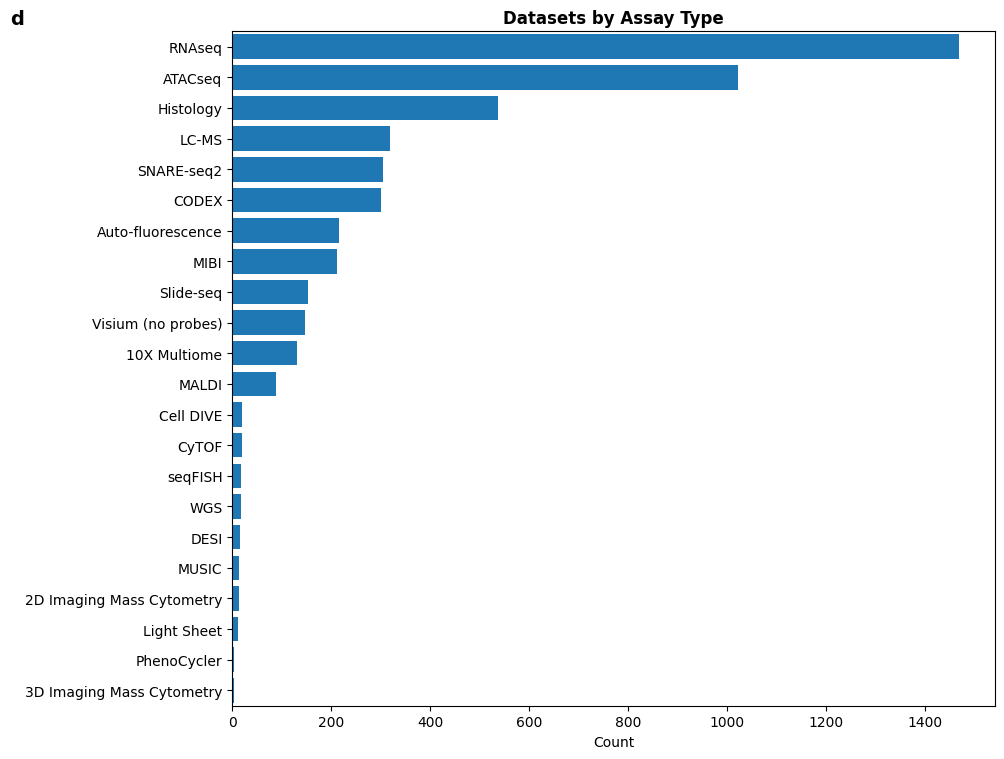

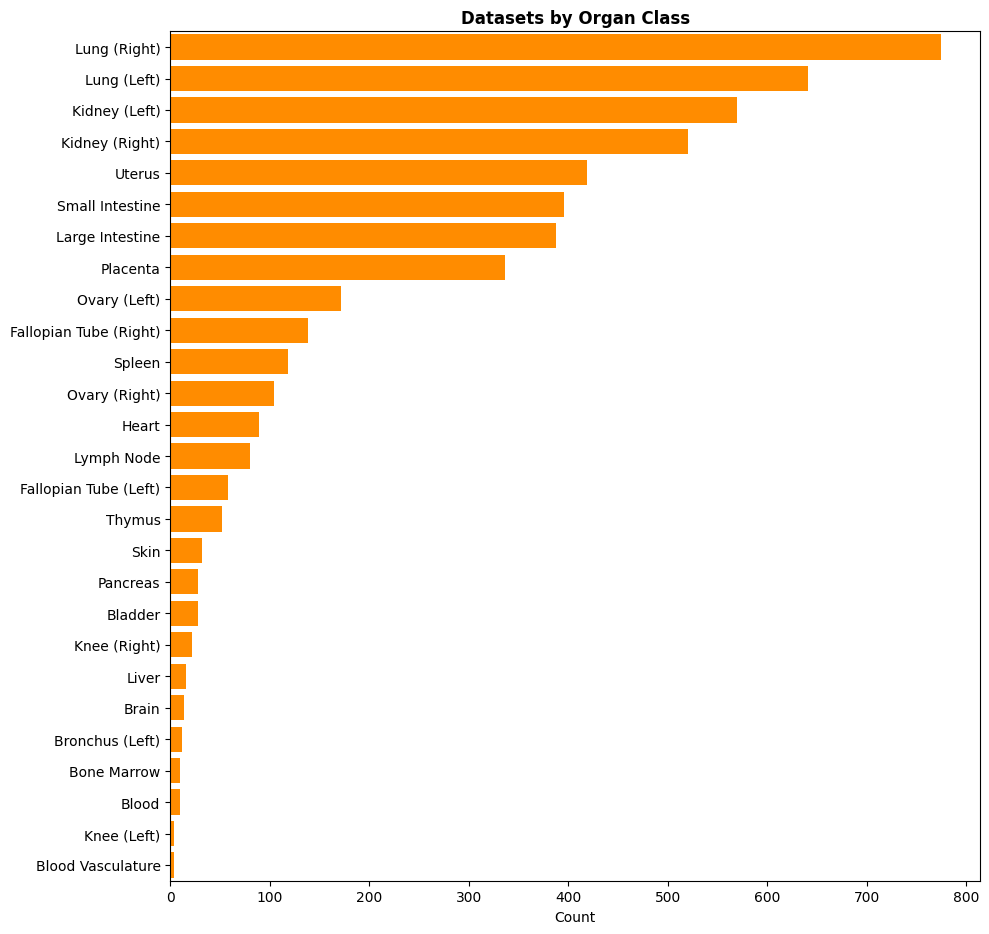